## SI epidemic simulations: communities

In [34]:
import networkx as nx
import EoN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec

from tqdm.notebook import tqdm

In [35]:
TAU = 0.1
TMAX = 20.0
N_TRIALS = 1
N_RUNS = 1

In [36]:
# Import Reddit Hyperlink network
edges = np.loadtxt('data/edges.csv', delimiter=',', dtype=int, skiprows=1)
G = nx.Graph()
G.add_edges_from(edges)

# Import communities
node_community = pd.read_csv('data/task1/communities.csv', index_col=0)

# Extract 5 largest communities
print(node_community.value_counts().head())

top_community_ids = node_community.value_counts().head().index.get_level_values(0).to_list()
top_community_nodes = {community_rank: node_community[node_community == community_id].dropna().index.to_list()
                       for community_rank, community_id in enumerate(top_community_ids)}

modularity_class
11                  5757
8                   5358
7                   4408
16                  2951
10                  2334
dtype: int64


### Functions

In [37]:
def simulate_si(G: nx.Graph, tau: float, tmax: float, top_community_nodes: dict[int, list[int]], initial_community: int, n_runs: int) -> np.ndarray:
    """Simulate SIR model for a given community and return the number of infected nodes at each time step. Returns an array of shape (n_runs, n_communities, n_time_steps)."""

    t_grid = np.linspace(0, tmax, 100)
    infected = np.zeros((n_runs, len(top_community_nodes), len(t_grid)))

    for run in range(n_runs):
        initial_infected = np.random.choice(top_community_nodes[initial_community])
        print(f"Initial infected: {initial_infected} (community {initial_community + 1})")
        
        sim = EoN.fast_SIR(G, tau, gamma=0, initial_infecteds=initial_infected, tmax=tmax, return_full_data=True)
        
        for community, nodes in top_community_nodes.items():
            I = [sum([1 for status in sim.get_statuses(nodes, t).values() if status == 'I']) for t in t_grid]
            infected[run, community] = I
        
    mean_infected = np.mean(infected, axis=0)

    return mean_infected

In [38]:
def run_trials(G: nx.Graph, tau: float, tmax: float, top_community_nodes: dict[int, list[int]], n_trials: int, n_runs: int) -> np.ndarray:
    """Run multiple trials for each community and return the average number of infected nodes at each time step. Returns an array of shape (n_trials, n_communities, n_time_steps)."""

    # Dictionary to store final results
    community_infected = {}

    for inital_community in top_community_nodes:

        # Array to store results of each trial
        mean_trial_infected = np.zeros((n_trials, len(top_community_nodes), len(np.linspace(0, TMAX, 100))))

        print(f"Community {inital_community + 1}")

        for trial in tqdm(range(n_trials)):

            # Run simulations
            mean_run_infected = simulate_si(G, tau=tau, tmax=tmax, n_runs=n_runs,
                                            top_community_nodes=top_community_nodes,
                                            initial_community=inital_community)

            # Store results
            mean_trial_infected[trial] = mean_run_infected

        # Average over trials
        mean_trial_infected = np.mean(mean_trial_infected, axis=0)

        # Store results
        community_infected[inital_community] = mean_trial_infected
    
    return community_infected

In [39]:
def plot_community_infected(community_infected: dict[int, np.ndarray], title: str, log: bool=False, save: bool=False) -> None:
    """Plot the number of infected nodes for each community at each time step."""

    fig = plt.figure(figsize=(6, 8))
    fig.suptitle(f"SI epidemic: infection curve\nfor top communities in {title} network\ntau={TAU}, tmax={TMAX}, n_trials={N_TRIALS}, n_runs={N_RUNS}")
    gs = gridspec.GridSpec(3, 4, figure=fig)

    axs = [fig.add_subplot(gs[0, :2])]
    axs += [fig.add_subplot(gs[0, 2:], sharex=axs[0], sharey=axs[0]),
            fig.add_subplot(gs[1, :2], sharex=axs[0], sharey=axs[0]),
            fig.add_subplot(gs[1, 2:], sharex=axs[0], sharey=axs[0]),
            fig.add_subplot(gs[2, :2], sharex=axs[0], sharey=axs[0])]

    for ax, (initial_community, data) in zip(axs, community_infected.items()):
        for i in range(5):
            ax.plot(np.linspace(0, TMAX, 100), data[i], label=f"Community {i + 1}")
        ax.set_title(f"Initial community: rank {initial_community + 1}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Infected nodes")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    legend = fig.legend(*ax.get_legend_handles_labels(), loc='lower right', bbox_to_anchor=(0.9, 0.1))

    if log:
        axs[0].set_yscale('log')

    fig.tight_layout()

    if save:
        fig.savefig(f"results/task3/tau{str(TAU).replace('.', '_')}_tmax{str(TMAX).replace('.', '_')}_ntrials{N_TRIALS}_nruns{N_RUNS}_{title.lower()}_{'log' if log else 'lin'}.png", dpi=fig.dpi, bbox_inches='tight')

    plt.show()

## Reddit graph

In [40]:
# Run trials
community_infected_reddit = run_trials(G, tau=TAU, tmax=TMAX, top_community_nodes=top_community_nodes, n_trials=N_TRIALS, n_runs=N_RUNS)

Community 1


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 16804 (community 1)
Community 2


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 8214 (community 2)
Community 3


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 4093 (community 3)
Community 4


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 8193 (community 4)
Community 5


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 8328 (community 5)


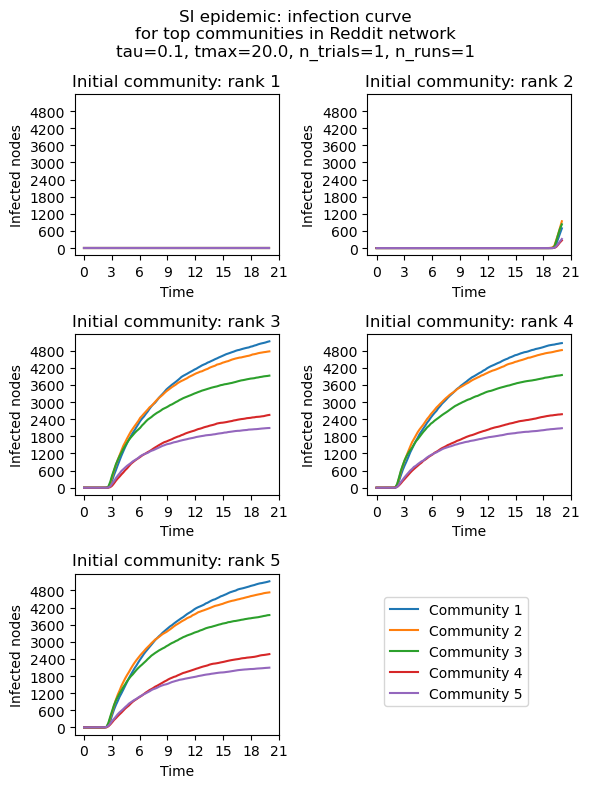

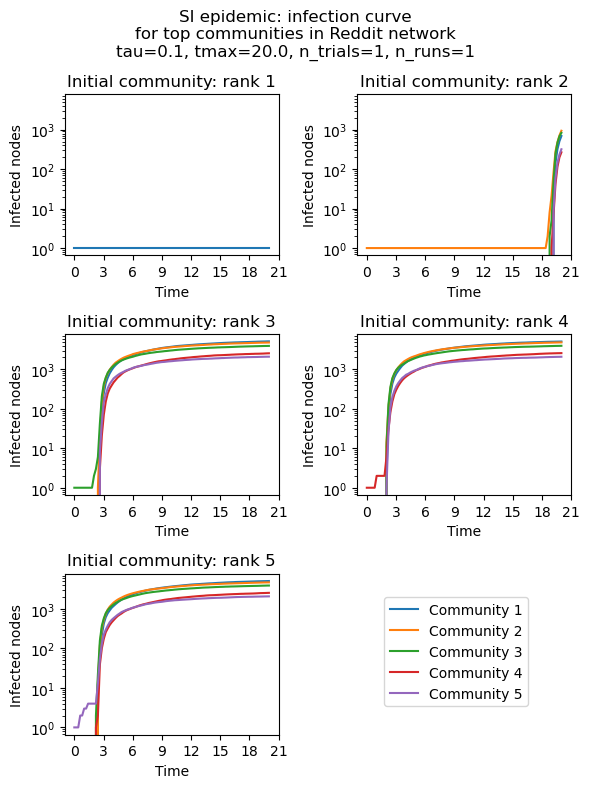

In [41]:
# Plot results
plot_community_infected(community_infected_reddit, title='Reddit', log=False, save=True)
plot_community_infected(community_infected_reddit, title='Reddit', log=True, save=True)

## Random graph

In [42]:
# Create random graph with same number of nodes and edges
G_random = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())

In [43]:
# Run trials
community_infected_random = run_trials(G_random, tau=TAU, tmax=TMAX, top_community_nodes=top_community_nodes, n_trials=N_TRIALS, n_runs=N_RUNS)

Community 1


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 18955 (community 1)
Community 2


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 30196 (community 2)
Community 3


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 8046 (community 3)
Community 4


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 16925 (community 4)
Community 5


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 20059 (community 5)


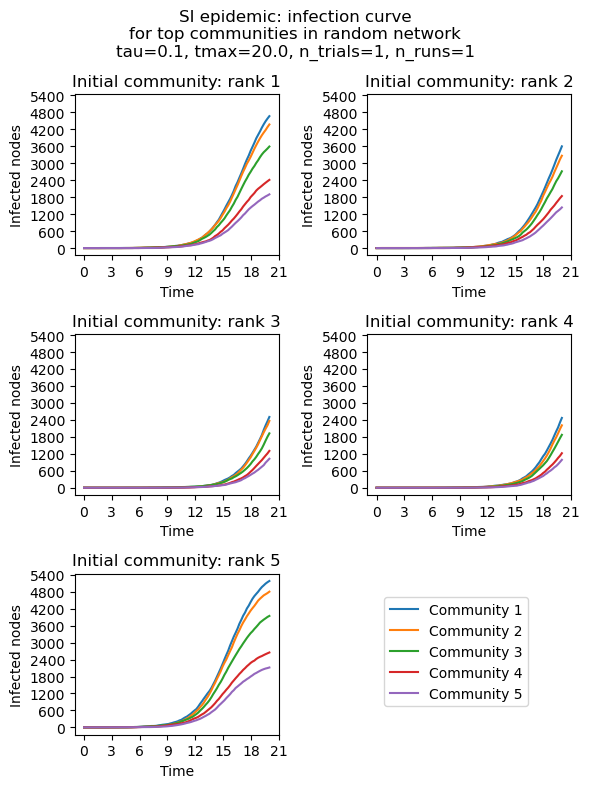

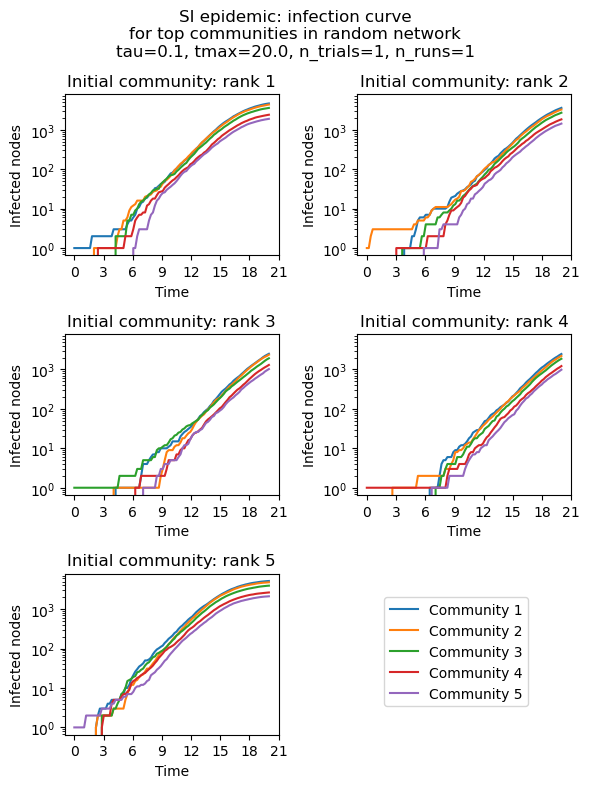

In [44]:
# Plot results
plot_community_infected(community_infected_random, title='random', log=False, save=True)
plot_community_infected(community_infected_random, title='random', log=True, save=True)